# Queries and visualization with DuckDB
I love DuckDB so much.

In [16]:
# Me irl: No brainer analyst
import pandas as pd 
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Setup connection with SQLite database
%load_ext sql
%sql sqlite:///../sales.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Testing: `DuckDB` demonstration

Sample code for storing query result into variable

In [4]:
%%sql result <<
SELECT * FROM accounts;

Returning data to local variable result


In [5]:
result

,index,id,name,website,lat,long,primary_poc,sales_rep_id
0,0,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
1,1,1011,Exxon Mobil,www.exxonmobil.com,41.169156,-73.849374,Sung Shields,321510
2,2,1021,Apple,www.apple.com,42.290495,-76.084009,Jodee Lupo,321520
3,3,1031,Berkshire Hathaway,www.berkshirehathaway.com,40.949021,-75.763898,Serafina Banda,321530
4,4,1041,McKesson,www.mckesson.com,42.217093,-75.284998,Angeles Crusoe,321540
...,...,...,...,...,...,...,...,...
346,346,4461,KKR,www.kkr.com,45.545353,-122.655247,Buffy Azure,321970
347,347,4471,Oneok,www.oneok.com,45.513513,-122.681500,Esta Engelhardt,321960
348,348,4481,Newmont Mining,www.newmont.com,45.494117,-122.669460,Khadijah Riemann,321970
349,349,4491,PPL,www.pplweb.com,45.491720,-122.671880,Deanne Hertlein,321960


### Queries and visualization (ft. `matplotlib` & `seaborns`)

Using `PRAGMA` for checking the information of the table

In [4]:
%%sql
-- Datatypes of orders 
PRAGMA table_info(accounts);

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,id,INTEGER,0,None,0
2,2,name,TEXT,0,None,0
3,3,website,TEXT,0,None,0
4,4,lat,REAL,0,None,0
5,5,long,REAL,0,None,0
6,6,primary_poc,TEXT,0,None,0
7,7,sales_rep_id,INTEGER,0,None,0


I've just forgot that SQLite limits users to alter the tables, to add foreign keys on that so I have to pretend that there are relationships between tables.

Ok goofy enough I will do something nice

In [6]:
%%sql
-- Checking distinct web channel are used 
SELECT DISTINCT(channel) FROM web_events;

,channel
0,direct
1,facebook
2,organic
3,adwords
4,twitter
5,banner


In [8]:
%%sql channel_rev <<
-- Let's do the join things
SELECT 
    DISTINCT(web_events.channel) AS "Channel",
    SUM(orders.total_amt_usd) AS "Total revenue (USD)"
FROM web_events 
    INNER JOIN accounts ON web_events.account_id = accounts.id
    INNER JOIN orders ON accounts.id = orders.account_id
GROUP BY web_events.channel;

Returning data to local variable channel_rev


In [9]:
# Check the channel revenue before plot the dataframe onto matplotlib
channel_rev

,Channel,Total revenue (USD)
0,adwords,9.777686e+07
1,banner,4.807840e+07
2,direct,6.396998e+08
3,facebook,1.030307e+08
4,organic,1.020503e+08
5,twitter,5.066669e+07


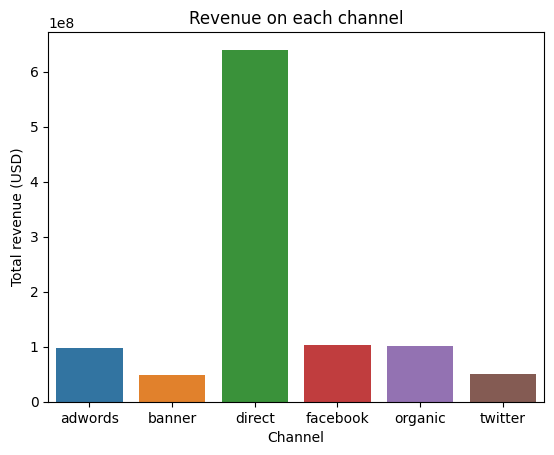

In [31]:
# matplotib in action
sns.barplot(data=channel_rev, x="Channel", y="Total revenue (USD)")
plt.title("Revenue on each channel")
plt.show()

In [15]:
%%sql 
SELECT
    region.name,
    COUNT(*) AS no_of_orders,
    ROUND(SUM(orders.total_amt_usd), 2) AS total_revenue
FROM orders 
    JOIN accounts ON orders.account_id = accounts.id 
    JOIN sales_reps ON accounts.sales_rep_id = sales_reps.id
    JOIN region ON sales_reps.region_id = region.id
GROUP BY region.name;

,name,no_of_orders,total_revenue
0,Midwest,897,3013486.51
1,Northeast,2357,7744405.36
2,Southeast,2024,6458497.00
3,West,1634,5925122.96


In [21]:
%%sql 
SELECT
    sales_reps.name,
    sales_reps.id,
    COUNT(orders.id) AS total_number_of_orders,
    SUM(orders.total_amt_usd) AS total_revenue
FROM sales_reps
    INNER JOIN accounts ON sales_reps.id = accounts.sales_rep_id
    INNER JOIN orders ON accounts.id = orders.account_id
GROUP BY sales_reps.name
ORDER BY total_number_of_orders DESC
LIMIT 5;

,name,id,total_number_of_orders,total_revenue
0,Earlie Schleusner,321800,335,1098137.72
1,Vernita Plump,321840,299,934212.93
2,Tia Amato,321640,267,1010690.60
3,Georgianna Chisholm,321970,256,886244.12
4,Moon Torian,321810,250,650393.52


Query ideas: Dealing with the sales representatives' output (number of orders, total revenues)

We would divide the divison of salesman to:

- More than 200: Top performer
- More than 150: Good performer
- More than 70: Decent performer
- Else: Low performer

In [26]:
%%sql
SELECT 
    sales_reps.name,
    COUNT(orders.id) AS total_number_of_order,
    CASE
        WHEN COUNT(orders.id) > 200 THEN 'Top performer'
        WHEN COUNT(orders.id) > 150 THEN 'Good performer'
        WHEN COUNT(orders.id) > 70 THEN 'Decent performer'
        ELSE 'Low performer'
    END AS sales_level,
    SUM(orders.total_amt_usd) AS total_revenue_each
FROM sales_reps 
    JOIN accounts ON sales_reps.id = accounts.sales_rep_id
    JOIN orders ON accounts.id = orders.account_id
GROUP BY sales_reps.name 
ORDER BY total_revenue_each DESC
LIMIT 10;

,name,total_number_of_order,sales_level,total_revenue_each
0,Earlie Schleusner,335,Top performer,1098137.72
1,Tia Amato,267,Top performer,1010690.60
2,Vernita Plump,299,Top performer,934212.93
3,Georgianna Chisholm,256,Top performer,886244.12
4,Arica Stoltzfus,186,Good performer,810353.34
5,Dorotha Seawell,208,Top performer,766935.04
6,Nelle Meaux,241,Top performer,749076.16
7,Sibyl Lauria,193,Good performer,722084.27
8,Maren Musto,224,Top performer,702697.29
9,Brandie Riva,167,Good performer,675917.64


Count the number of each salesman's division

In [27]:
%%sql
WITH salesman_report AS (
    SELECT 
        sales_reps.name,
        COUNT(orders.id) AS total_number_of_order,
        CASE
            WHEN COUNT(orders.id) > 200 THEN 'Top performer'
            WHEN COUNT(orders.id) > 150 THEN 'Good performer'
            WHEN COUNT(orders.id) > 70 THEN 'Decent performer'
            ELSE 'Low performer'
        END AS sales_level,
        SUM(orders.total_amt_usd) AS total_revenue_each
    FROM sales_reps 
        JOIN accounts ON sales_reps.id = accounts.sales_rep_id
        JOIN orders ON accounts.id = orders.account_id
    GROUP BY sales_reps.name
)

SELECT 
    DISTINCT(sales_level) AS "Sales division",
    COUNT(sales_level) AS "Number of salesmen"
FROM salesman_report
GROUP BY sales_level;

,Sales division,Number of salesmen
0,Decent performer,15
1,Good performer,12
2,Low performer,13
3,Top performer,10


Testing the nested query

In [32]:
%%sql division_numbers <<
SELECT 
    DISTINCT(sales_level) AS "Sales division",
    COUNT(sales_level) AS "Number of salesmen"
FROM (
    SELECT 
        sales_reps.name,
        COUNT(orders.id) AS total_number_of_order,
        CASE
            WHEN COUNT(orders.id) > 200 THEN 'Top performer'
            WHEN COUNT(orders.id) > 150 THEN 'Good performer'
            WHEN COUNT(orders.id) > 70 THEN 'Decent performer'
            ELSE 'Low performer'
        END AS sales_level,
        SUM(orders.total_amt_usd) AS total_revenue_each
    FROM sales_reps 
        JOIN accounts ON sales_reps.id = accounts.sales_rep_id
        JOIN orders ON accounts.id = orders.account_id
    GROUP BY sales_reps.name
)
GROUP BY sales_level;

Returning data to local variable division_numbers


In [33]:
division_numbers

,Sales division,Number of salesmen
0,Decent performer,15
1,Good performer,12
2,Low performer,13
3,Top performer,10


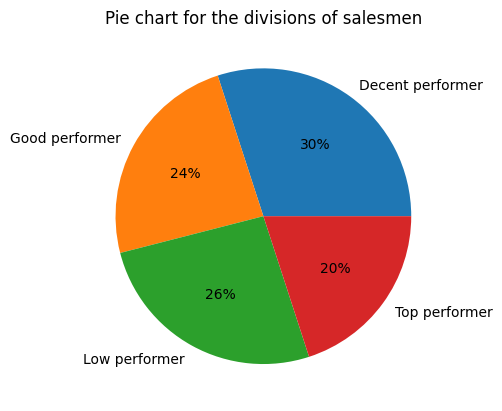

In [39]:
plt.pie(data=division_numbers,x="Number of salesmen", labels="Sales division", autopct='%.0f%%')
plt.title("Pie chart for the divisions of salesmen")
plt.show()